In [4]:

# Install FEniCS
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install-release-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

--2025-03-19 12:12:23--  https://fem-on-colab.github.io/releases/fenics-install-release-real.sh
Resolving fem-on-colab.github.io (fem-on-colab.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to fem-on-colab.github.io (fem-on-colab.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4180 (4.1K) [application/x-sh]
Saving to: ‘/tmp/fenics-install.sh’

/tmp/fenics-install 100%[===================>]   4.08K  --.-KB/s    in 0s      

2025-03-19 12:12:23 (19.1 MB/s) - ‘/tmp/fenics-install.sh’ saved [4180/4180]

+ INSTALL_PREFIX=/usr/local
++ echo /usr/local
++ awk -F/ '{print NF-1}'
+ INSTALL_PREFIX_DEPTH=2
+ PROJECT_NAME=fem-on-colab
+ SHARE_PREFIX=/usr/local/share/fem-on-colab
+ FENICS_INSTALLED=/usr/local/share/fem-on-colab/fenics.installed
+ [[ ! -f /usr/local/share/fem-on-colab/fenics.installed ]]
+ PYBIND11_INSTALL_SCRIPT_PATH=https://github.com/fem-on-colab/fem-on-colab.github.io/raw/1f33a7ab/releases/pybi

In [5]:
# Install RBniCS
try:
    import rbnics
except ImportError:
    !pip3 install git+https://github.com/RBniCS/RBniCS.git
    import rbnics
import rbnics.utils.config
assert "dolfin" in rbnics.utils.config.config.get("backends", "required backends")

  Cloning https://github.com/RBniCS/RBniCS.git to /tmp/pip-req-build-unamv9v3
  Running command git clone --filter=blob:none --quiet https://github.com/RBniCS/RBniCS.git /tmp/pip-req-build-unamv9v3
  Resolved https://github.com/RBniCS/RBniCS.git to commit b23d20d68d22579c0995b16025f7f1e858d65259
  Preparing metadata (setup.py) ... done
  Created wheel for RBniCS: filename=RBniCS-0.2.0-py3-none-any.whl size=598339 sha256=543002ac8322123f7a4dad1b63fa0d6778023235141e1a8240925cd4578e50d6
  Stored in directory: /tmp/pip-ephem-wheel-cache-du03la65/wheels/91/6e/53/8e8074380bbeb5ca55786b492fcb71afa192955accca0a7cea
Successfully built RBniCS


In [6]:
from dolfin import *
from rbnics import *

## 5. Assignments


Create another copy of this notebook, and change the model reduction technique from POD-Galerkin to certified reduced basis. You may need to add a new method in the ElasticBlock class which is currently missing. Compare the results of the error analysis and speedup analysis for the two reduction techniques.

In [7]:
class ElasticBlock(EllipticCoerciveProblem):

    # Default initialization of members
    def __init__(self, V, **kwargs):
        # Call the standard initialization
        EllipticCoerciveProblem.__init__(self, V, **kwargs)
        # ... and also store FEniCS data structures for assembly
        assert "subdomains" in kwargs
        assert "boundaries" in kwargs
        self.subdomains, self.boundaries = kwargs["subdomains"], kwargs["boundaries"]
        self.u = TrialFunction(V)
        self.v = TestFunction(V)
        self.dx = Measure("dx")(subdomain_data=self.subdomains)
        self.ds = Measure("ds")(subdomain_data=self.boundaries)
        # ...
        self.f = Constant((1.0, 0.0))
        self.E = 1.0
        self.nu = 0.3
        self.lambda_1 = self.E * self.nu / ((1.0 + self.nu) * (1.0 - 2.0 * self.nu))
        self.lambda_2 = self.E / (2.0 * (1.0 + self.nu))

    # Return custom problem name
    def name(self):
        return "ElasticBlock"

    # Return the alpha_lower bound.               #  Add this Codes by XKY
    def get_stability_factor_lower_bound(self):
        return min(self.compute_theta("a"))

    # Return theta multiplicative terms of the affine expansion of the problem.
    def compute_theta(self, term):
        mu = self.mu
        if term == "a":
            theta_a0 = mu[0]
            theta_a1 = mu[1]
            theta_a2 = mu[2]
            theta_a3 = mu[3]
            theta_a4 = mu[4]
            theta_a5 = mu[5]
            theta_a6 = mu[6]
            theta_a7 = mu[7]
            theta_a8 = 1.
            return (theta_a0, theta_a1, theta_a2, theta_a3, theta_a4, theta_a5, theta_a6, theta_a7, theta_a8)
        elif term == "f":
            theta_f0 = mu[8]
            theta_f1 = mu[9]
            theta_f2 = mu[10]
            return (theta_f0, theta_f1, theta_f2)
        else:
            raise ValueError("Invalid term for compute_theta().")

    # Return forms resulting from the discretization of the affine expansion of the problem operators.
    def assemble_operator(self, term):
        v = self.v
        dx = self.dx
        if term == "a":
            u = self.u
            a0 = self.elasticity(u, v) * dx(1)
            a1 = self.elasticity(u, v) * dx(2)
            a2 = self.elasticity(u, v) * dx(3)
            a3 = self.elasticity(u, v) * dx(4)
            a4 = self.elasticity(u, v) * dx(5)
            a5 = self.elasticity(u, v) * dx(6)
            a6 = self.elasticity(u, v) * dx(7)
            a7 = self.elasticity(u, v) * dx(8)
            a8 = self.elasticity(u, v) * dx(9)
            return (a0, a1, a2, a3, a4, a5, a6, a7, a8)
        elif term == "f":
            ds = self.ds
            f = self.f
            f0 = inner(f, v) * ds(2)
            f1 = inner(f, v) * ds(3)
            f2 = inner(f, v) * ds(4)
            return (f0, f1, f2)
        elif term == "dirichlet_bc":
            bc0 = [DirichletBC(self.V, Constant((0.0, 0.0)), self.boundaries, 6)]
            return (bc0,)
        elif term == "inner_product":
            u = self.u
            x0 = inner(u, v) * dx + inner(grad(u), grad(v)) * dx
            return (x0,)
        else:
            raise ValueError("Invalid term for assemble_operator().")

    # Auxiliary function to compute the elasticity bilinear form
    def elasticity(self, u, v):
        lambda_1 = self.lambda_1
        lambda_2 = self.lambda_2
        return 2.0 * lambda_2 * inner(sym(grad(u)), sym(grad(v))) + lambda_1 * tr(sym(grad(u))) * tr(sym(grad(v)))

## 4. Main program
### 4.1. Read the mesh for this problem
The mesh was generated by the [data/generate_mesh.ipynb](data/generate_mesh.ipynb) notebook.

In [10]:
mesh = Mesh("data/elastic_block.xml")
subdomains = MeshFunction("size_t", mesh, "data/elastic_block_physical_region.xml")
boundaries = MeshFunction("size_t", mesh, "data/elastic_block_facet_region.xml")

### 4.2. Create Finite Element space (Lagrange P1)

In [19]:
V = VectorFunctionSpace(mesh, "Lagrange", 2)      # change this code

### 4.3. Allocate an object of the ElasticBlock class

In [20]:
problem = ElasticBlock(V, subdomains=subdomains, boundaries=boundaries)
mu_range = [
    (1.0, 100.0),
    (1.0, 100.0),
    (1.0, 100.0),
    (1.0, 100.0),
    (1.0, 100.0),
    (1.0, 100.0),
    (1.0, 100.0),
    (1.0, 100.0),
    (-1.0, 1.0),
    (-1.0, 1.0),
    (-1.0, 1.0)
]
problem.set_mu_range(mu_range)

### 4.4. Prepare reduction with a POD-Galerkin method

In [21]:
reduction_method = ReducedBasis(problem)        # change this code
reduction_method.set_Nmax(5)
reduction_method.set_tolerance(1e-5)

### 4.5. Perform the offline phase

In [22]:
reduction_method.initialize_training_set(100)
reduced_problem = reduction_method.offline()

### 4.6. Perform an online solve

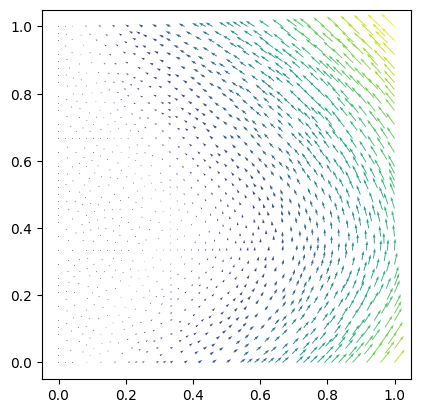

In [23]:
online_mu = (1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -1.0, -1.0)
reduced_problem.set_mu(online_mu)
reduced_solution = reduced_problem.solve()
plot(reduced_solution, reduced_problem=reduced_problem)

### 4.7. Perform an error analysis

In [24]:
reduction_method.initialize_testing_set(100)
reduction_method.error_analysis()

=               ElasticBlock RB error analysis begins                =

################################# 0 ##################################
################################# 1 ##################################
################################# 2 ##################################
################################# 3 ##################################
################################# 4 ##################################
################################# 5 ##################################
################################# 6 ##################################
################################# 7 ##################################
################################# 8 ##################################
################################# 9 ##################################
################################# 10 #################################
################################# 11 #################################
################################# 12 #################################
#####

### 4.8. Perform a speedup analysis

In [25]:
reduction_method.initialize_testing_set(100)
reduction_method.speedup_analysis()

=              ElasticBlock RB speedup analysis begins               =

################################# 0 ##################################
################################# 1 ##################################
################################# 2 ##################################
################################# 3 ##################################
################################# 4 ##################################
################################# 5 ##################################
################################# 6 ##################################
################################# 7 ##################################
################################# 8 ##################################
################################# 9 ##################################
################################# 10 #################################
################################# 11 #################################
################################# 12 #################################
#####

## 5. Assignments
1. Consider now the simplified problem in which
$$
\mu_0 \equiv \mu_1 \equiv \mu_2 \quad \text{and} \quad \mu_3 \equiv \mu_4 \equiv \mu_5 \quad \text{and} \quad
\mu_6 \equiv \mu_7 = 1 \quad \text{and} \quad \mu_8 \equiv \mu_9 \equiv \mu_{10}
$$
Denote by $\boldsymbol{\eta} = (\mu_0, \mu_3, \mu_8)$ the parameter vector of the simplified problem, defined on the parameter domain $\mathbb{Q}=[1,100]^2\times[-1,1]$.
Implement the simplified problem in a copy of this notebook. What do you observe for what concerns the POD eigenvalue, error analysis, speedup analysis? _Suggestion: for every new notebook copy change the value returned by the name() method of the ElasticBlock class to avoid conflicts between this notebook and your copy_.

2. Create another copy of this notebook, and change the model reduction technique from POD-Galerkin to certified reduced basis. You may need to add a new method in the ElasticBlock class which is currently missing. Compare the results of the error analysis and speedup analysis for the two reduction techniques.
